### Importing packages

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import os
from dask import bag
from dask import diagnostics
from keras.utils import load_img
import tensorflow as tf

### Identifying Class Imbalance

In [41]:
number_classes = {'Acne': len(os.listdir('../src/disease_dataset/Acne')),
'Cyst, Tumor': len(os.listdir('../src/disease_dataset/Cyst, tumour and skin-tags')),
'Melanoma': len(os.listdir('../src/disease_dataset/Melanoma')),
'Moneypox': len(os.listdir('../src/disease_dataset/Moneypox')),
'Normal skin': len(os.listdir('../src/disease_dataset/Normal skin'))}

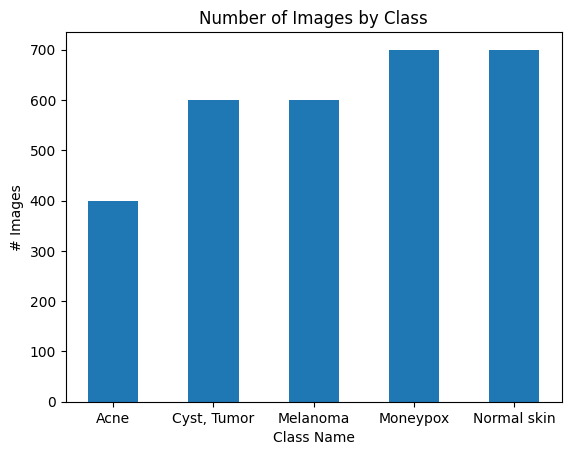

In [42]:
plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

### Plotting Image Size

In [43]:
directories = {'Acne': '../src/disease_dataset/Acne/',
'Cyst, Tumor': '../src/disease_dataset/Cyst, tumour and skin-tags/',
'Melanoma': '../src/disease_dataset/Melanoma/',
'Moneypox': '../src/disease_dataset/Moneypox/',
'Normal skin': '../src/disease_dataset/Normal skin/'}

def get_dims(file):
    '''
    Returns dimensions for an RBG image
    '''
    im = Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w

[########################################] | 100% Completed | 2.39 ss
[########################################] | 100% Completed | 2.41 ss
[########################################] | 100% Completed | 5.82 ss
[########################################] | 100% Completed | 3.19 ss
[########################################] | 100% Completed | 3.08 ss


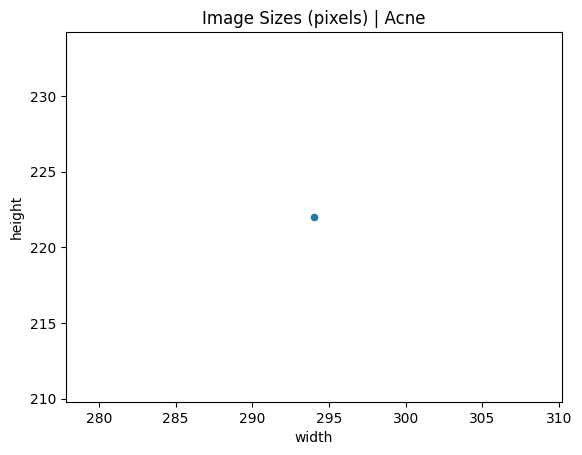

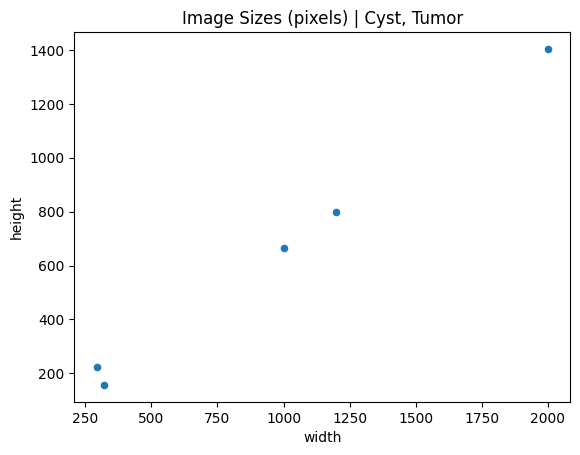

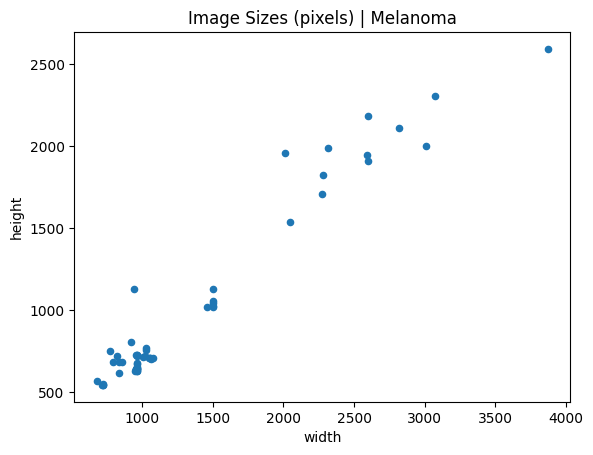

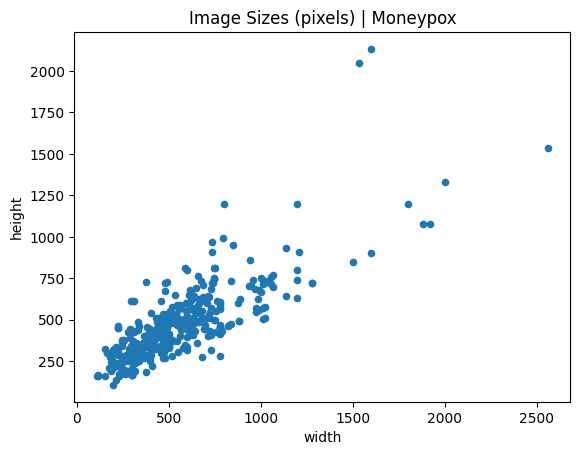

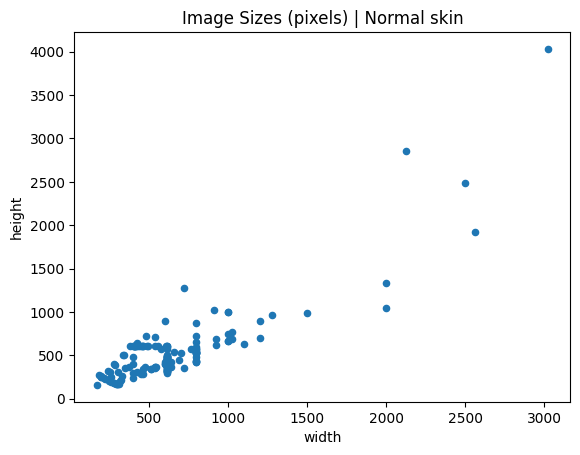

In [44]:
for n,d in directories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = bag.from_sequence(filelist).map(get_dims)
    with diagnostics.ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height');
        plt.title('Image Sizes (pixels) | {}'.format(n))

### Get the list of jpegs from sub image class folders

In [45]:
train_dir = '../src/disease_dataset' # image folder

acne_imgs = [fn for fn in os.listdir(f'{train_dir}/Acne') if fn.endswith('.jpg')]
cyst_imgs = [fn for fn in os.listdir(f'{train_dir}/Cyst, tumour and skin-tags') if fn.endswith('.jpg')]
melanoma_imgs = [fn for fn in os.listdir(f'{train_dir}/Melanoma') if fn.endswith('.jpg')]
monkeypox_imgs = [fn for fn in os.listdir(f'{train_dir}/Moneypox') if fn.endswith('.jpg')]
normal_imgs = [fn for fn in os.listdir(f'{train_dir}/Normal skin') if fn.endswith('.jpg')]

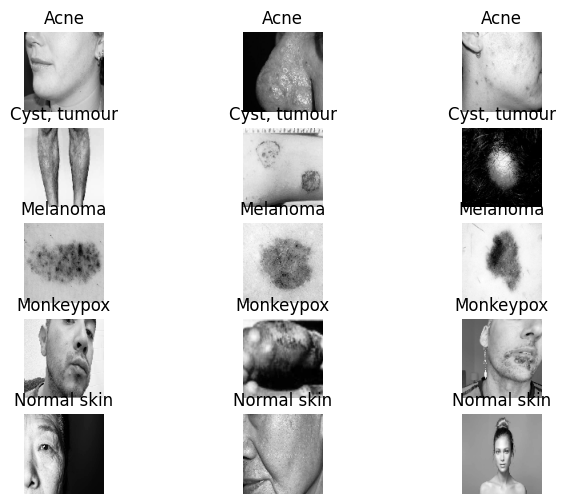

In [46]:
# randomly select 3 of each
select_acne = np.random.choice(acne_imgs, 3, replace = False)
select_cyst = np.random.choice(cyst_imgs, 3, replace = False)
select_melanoma = np.random.choice(melanoma_imgs, 3, replace = False)
select_monkeypox = np.random.choice(monkeypox_imgs, 3, replace = False)
select_normal = np.random.choice(normal_imgs, 3, replace = False)

# plotting 5 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(15):
    if i < 3:
        fp = f'{train_dir}/Acne/{select_acne[i]}'
        label = 'Acne'
    elif 3 <= i < 6:
        fp = f'{train_dir}/Cyst, tumour and skin-tags/{select_cyst[i-3]}'
        label = 'Cyst, tumour'
    elif 6 <= i < 9:
        fp = f'{train_dir}/Melanoma/{select_melanoma[i-6]}'
        label = 'Melanoma'
    elif 9 <= i < 12:
        fp = f'{train_dir}/Moneypox/{select_monkeypox[i-9]}'
        label = 'Monkeypox'
    else:
        fp = f'{train_dir}/Normal skin/{select_normal[i-12]}'
        label = 'Normal skin'
    ax = fig.add_subplot(5, 3, i+1)

    # to plot without rescaling, remove target_size
    fn = load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

### Print length of normal images

In [47]:
# also check the number of files here
len(acne_imgs), len(cyst_imgs), len(melanoma_imgs), len(monkeypox_imgs), len(normal_imgs)

(390, 592, 600, 700, 700)

### Images as Matrix

In [48]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = load_img(fp, target_size = size,
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = tf.keras.utils.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError:
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
acne_images = img2np(f'{train_dir}/Acne/', acne_imgs)
cyst_images = img2np(f'{train_dir}/Cyst, tumour and skin-tags/', cyst_imgs)
melanoma_images = img2np(f'{train_dir}/Melanoma/', melanoma_imgs)
monkeypox_images = img2np(f'{train_dir}/Moneypox/', monkeypox_imgs)
normal_images = img2np(f'{train_dir}/Normal skin/', normal_imgs)


In [49]:
print(acne_images)

[[ 20.  21.  22. ...  62.  57.  53.]
 [  5.   5.   5. ...  74.  53.  61.]
 [103.  88.  89. ... 120. 122. 118.]
 ...
 [150. 137. 140. ...  28.  25.  26.]
 [ 58.  82. 103. ...  31.  32.  30.]
 [ 96.  78.  89. ...  82.  87.  85.]]


### Average Image

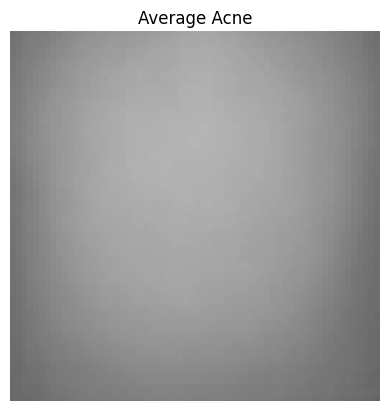

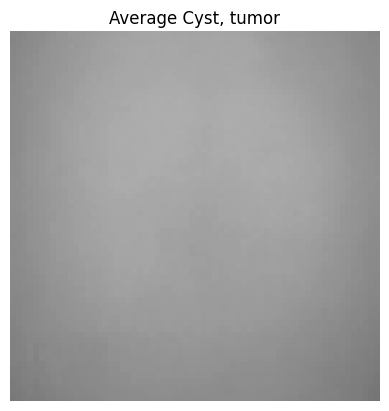

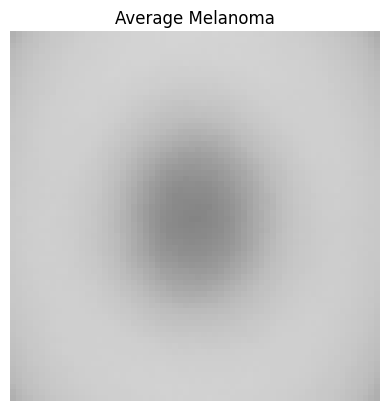

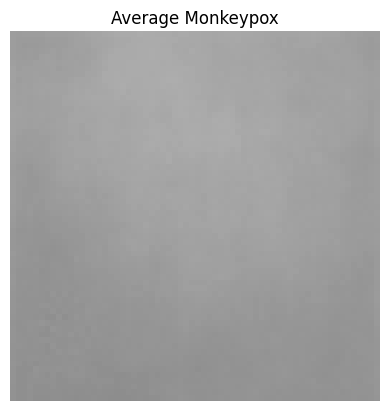

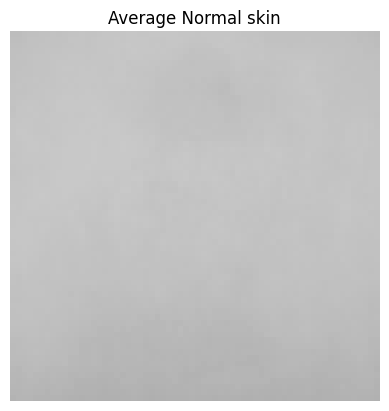

In [50]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

acne_mean = find_mean_img(acne_images, 'Acne')
cyst_mean = find_mean_img(cyst_images, 'Cyst, tumor')
melanoma_mean = find_mean_img(melanoma_images, 'Melanoma')
monkeypox_mean = find_mean_img(monkeypox_images, 'Monkeypox')
normal_mean = find_mean_img(normal_images, 'Normal skin')

### Eigenimages

Number of PC:  5


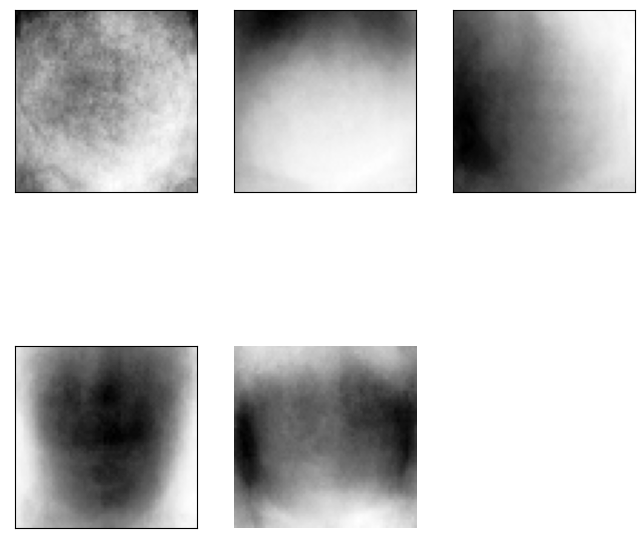

Number of PC:  5


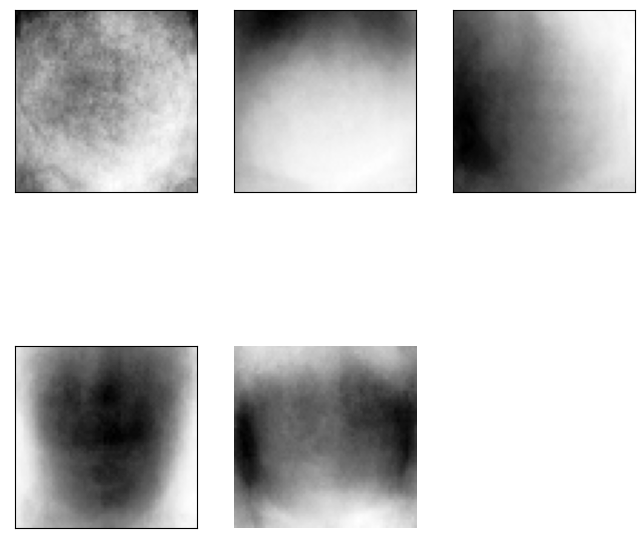

Number of PC:  5


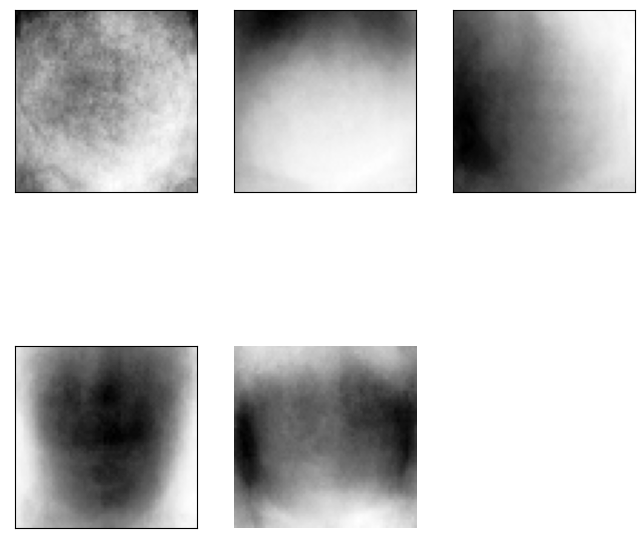

Number of PC:  5


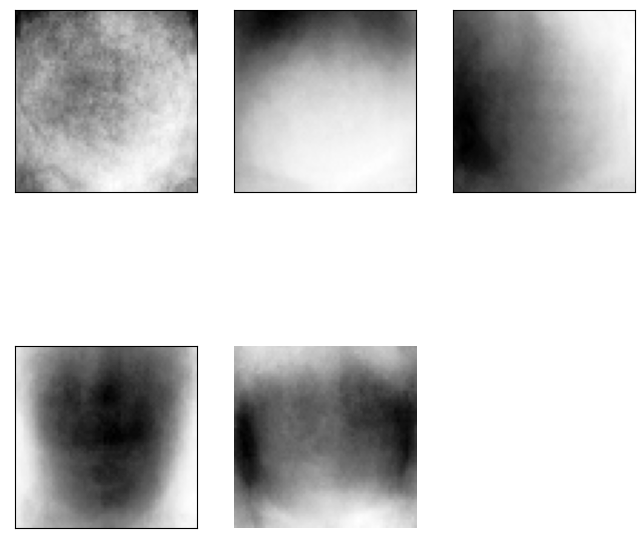

Number of PC:  8


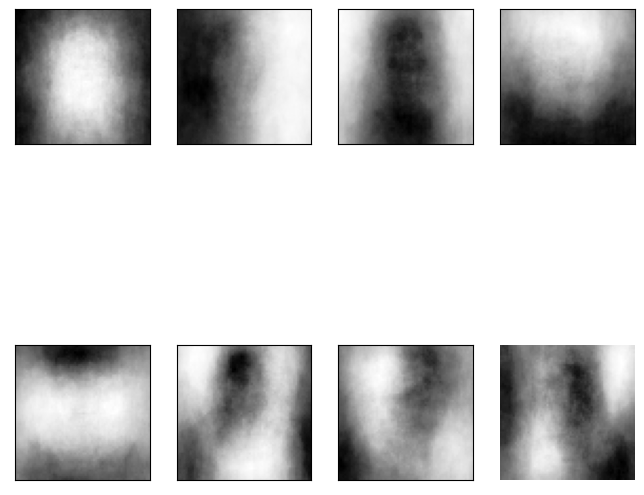

In [51]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca

def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size),
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()

plot_pca(eigenimages(acne_images, 'Acne'))
plot_pca(eigenimages(acne_images, 'Cyst, tumor'))
plot_pca(eigenimages(acne_images, 'Melanoma'))
plot_pca(eigenimages(acne_images, 'Monkeypox'))
plot_pca(eigenimages(normal_images, 'Normal skin'))